# Generalized pencil-of-function

Date: 2022-08-11  
Author: Pedro H. N. Vieira  
Categories: Generalized pencil-of-function, GPOF, ajuste de função  
Tags: julia, GPOF  
<!--eofm-->

## Motivação

Qualquer sinal linear pode ser decomposto numa [Série de Fourier](https://pt.wikipedia.org/wiki/S%C3%A9rie_de_Fourier), isto é, uma soma de senos e cossenos. Ademais, a [Identidade de Euler](https://pt.wikipedia.org/wiki/Identidade_de_Euler) nos permite expressar senos e cossenos usando exponenciais complexas, pois
$$e^{j x} = \exp(j x) = \cos(x) + j\sin(x)$$
onde $j=\sqrt{-1}$.

Ao fazer isto, podemos saber a taxa de amortecimento e a frequência de oscilação das várias componentes de um sinal.

Seja um sinal $y(t)$ amostrado num intervalo $\Delta t$. Deseja-se ajustar tal sinal por uma soma de $M$ exponenciais complexas. Pode-se utilizar o método generalizado de lápis-de-função (*Generalized pencil-of-function method*, GPOF), tal como descrito em [[1]](#1).

## Algoritmo

A seguir é descrito o algoritmo do GPOF, mas não a sua dedução. Para isto, os interessados devem ler o artigo [[1]](#1).

Dado o sinal amostrado $y_k$, assume-se a aproximação

$$
y_k \approx \sum_{i=1}^M b_i \exp(s_i\, \Delta t\, k) \qquad k=0,1,\dots,N-1
$$

Se $y_k$ for um sinal real, então os resíduos complexos $b_i$ e os pólos complexos $s_i$ aparecerão em pares conjugados.

Monta-se uma matriz $\mathbb Y$ utilizando os vetores de informação $\mathbb{y}_i$.

$$
\mathbb{y}_i = [y_i, y_{i+1}, \dots, y_{i+N-L-1}]^T
$$

$$
\mathbb Y = [\mathbb{y}_i, \mathbb{y}_{i+1}, \dots, \mathbb{y}_{L}]^T
$$

A matriz $\mathbb{Y}$ tem dimensões $(N-L) \times (L+1)$. É recomendado escolher o parâmetro $L$ tal que
$$
\frac{N}{3} \le L \le \frac{N}{2}.
$$

Define-se uma matriz $Y_1$ utilizando as $L$ primeiras colunas de $\mathbb Y$. Define-se, também, uma matriz $Y_2$ utilizando as $L$ últimas colunas de $\mathbb Y$. Então, decompõe-se a matriz $Y_1$ em seus [valores singulares](https://pt.wikipedia.org/wiki/Decomposi%C3%A7%C3%A3o_em_valores_singulares):

$$
Y_1 = UDV^H
$$

A partir desta decomposição, descartam-se os $N-M$ valores singulares menos significantes (a partir de uma tolerância arbitrária) e, então, calcula-se a matriz $Z$. Na prática, isto significa utilizar apenas as $M$ primeiras colunas de $U$ e $V$.

$$
Z = D^{-1} U^H Y_2 V
$$

Os autovalores $z_i$ desta matriz $Z$ são os pólos no plano Z. Os pólos $s_i$ no plano S podem ser calculados por
$$s_i = \frac{\ln z_i}{\Delta t}.$$

A partir dos pólos $z_i$ no plano Z, calculam-se os resíduos $b_i$ resolvendo-se o seguinte sistema linear sobredeterminado (utilizando, por exemplo, o [Método dos Mínimos Quadrados](https://pt.wikipedia.org/wiki/M%C3%A9todo_dos_m%C3%ADnimos_quadrados)):

$$\begin{bmatrix} z_1^{0} & z_2^{0} & \dots & z_M^{0} \\ z_1^{1} & z_2^{1} & \dots & z_M^{1} \\ \vdots & \vdots & \ddots & \vdots \\ z_1^{N-1} & z_2^{N-1} & \dots & z_M^{N-1} \end{bmatrix} \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_M \\ \end{bmatrix} = \begin{bmatrix} y_0 \\ y_1 \\ \vdots \\ y_{N-1} \\ \end{bmatrix}$$

In [1]:
using LinearAlgebra
using Plots
using Distributions
import Printf.@printf

In [2]:
"""
Faz o ajuste do sinal X usando o método descrito em:

Hua, Yingbo, and Tapan K. Sarkar.
"Generalized pencil-of-function method for extracting poles of an EM system from its transient response."
IEEE transactions on antennas and propagation 37.2 (1989): 229-234.

O ajuste pode ser calculado por
    X_ajustado = [sum(ri .* zi.^k) for k = 0:(N - 1)]
"""
function gpof(x, tol=0)
    N = length(x)
    L = ((N ÷ 2) + (N ÷ 3)) ÷ 2  # N/3 ≤ L ≤ N/2
    y = Array{ComplexF64}(undef, (N - L, L + 1))
    for k = 1:(L + 1)
        for i = 1:(N - L)
            y[i,k] = x[i + k - 1]
        end
    end
    y1 = @view y[:,1:L]
    y2 = @view y[:,2:(L + 1)]
    Fy = svd(y1)
    # Valores singulares são retornados em ordem; descartar os insignificantes
    M = sum(@. Fy.S / Fy.S[1] > tol)
    D_inv = diagm(1 ./ Fy.S[1:M])
    Z = D_inv * adjoint(Fy.U[:, 1:M]) * y2 * Fy.V[:, 1:M]
    Fz = eigen(Z)
    zi = Fz.values  # pólos
    zm = Array{ComplexF64}(undef, (N, M))
    for k = 1:M
        for i = 1:N
            zm[i,k] = zi[k]^(i - 1)
        end
    end
    ri = zm \ x  # resíduos
    return zi, ri
end

gpof

RMSE = 5.62e-17 para ruído = 0
RMSE = 9.51e-05 para ruído = 0.001
RMSE = 7.37e-03 para ruído = 0.1


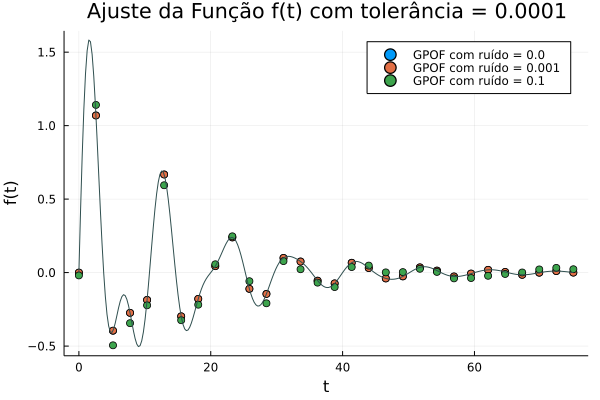

In [3]:
# Testar GPOF
tol = 1e-4
w = [0.2π, 0.35π]
a = [0.02π, 0.035π]
b = ones(2)
foo(t) = sum(@. b * exp(-a * t) * sin(w * t))
Nt = 300
tf = 75
t = range(0, tf, length=Nt)
y = foo.(t)
Nsample = 30
tsample = range(0, tf, length=Nsample)
ysample = foo.(tsample)
py = plot(title="Ajuste da Função f(t) com tolerância = $(tol)", xlabel="t", ylabel="f(t)")
for noise in [0, 1e-3, 0.1]
    ynoisy = x = ysample .+ rand(Uniform(-1,1), Nsample) * noise
    zi, ri = gpof(ynoisy, tol)
    fit = real([sum(ri .* zi.^k) for k = 0:(Nsample - 1)])
    scatter!(py, tsample, fit, label="GPOF com ruído = $(noise)")
    @printf "RMSE = %.2e para ruído = %g\n"  sqrt(sum((fit - ysample).^2)) / Nsample  noise
end
plot!(py, t, y, label="", color=:darkslategray)
py

## Referências

<a name="1"></a>[1] HUA, Yingbo; SARKAR, Tapan K. Generalized pencil-of-function method for extracting poles of an EM system from its transient response. **IEEE transactions on antennas and propagation**, v. 37, n. 2, p. 229-234, 1989.